# 模式识别导论 实验一

赖永凡 PB20061210

## 数据预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('./diabetes.csv')
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [2]:
col_to_do = data.columns[1:-1]
data[col_to_do] = data[col_to_do].replace(0, np.nan)
medians = data.median()
data = data.fillna(medians)
data.to_csv('data_processed.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


## 5折交叉验证

In [3]:
Y, X = data['Outcome'], data.drop(["Outcome"], axis=1)
n_folds = 5
X_Folds, Y_Folds = {}, {}
length = len(data) // 5
for i in range(n_folds):
    X_Folds[i] = X[i*length:(i+1)*length]
    Y_Folds[i] = Y[i*length:(i+1)*length]

In [4]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler() 

for i in range(n_folds):
    X_Folds[i] = ss.fit_transform(X_Folds[i]) 
    X_Folds[i] = pd.DataFrame(columns=X.columns, data=X_Folds[i])

X_Folds[0].head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.562001,0.972908,0.024435,0.700843,-0.155405,0.180087,0.477626,1.428072
1,-0.920518,-1.107824,-0.415398,-0.020428,-0.155405,-0.829191,-0.320648,-0.219311
2,1.155008,2.128871,-0.562009,-0.020428,-0.155405,-1.304993,0.607779,-0.132607
3,-0.920518,-0.975714,-0.415398,-0.741699,-0.500483,-0.612917,-0.852830,-1.086355
4,-1.217022,0.609606,-2.321342,0.700843,0.323251,1.549821,5.281728,-0.045902


## Logistic Regression 分类器

In [7]:
def sigmoid(x):
    if x >= 0:
        z = np.exp(-x)
        return 1 / (1 + z)
    else:
        z = np.exp(x)
        return z / (1 + z)
    
sigmoid = np.vectorize(sigmoid)

class LogisticClassifier:
    '''
    Binomial Logistic Regression using GD, SGD, or mini-batch SGD with L2 regularization.
    '''

    def __init__(self, alpha=0.001, lambda_=0.01, max_iter=500, random_state=0):
        self.alpha = alpha # Learning rate
        self.max_iter = max_iter
        self.random_state = random_state # random seed
        self.lambda_ = lambda_

        self.n = None  # Number of samples
        self.d = None  # Number of features
        self.X = None  # Feature matrix with bias
        self.y = None  # Label vector
        self.w = None  # Weight vector
        self.score_list = []


    def fit(self, X, y, show_info=False):
        np.random.seed(self.random_state)
        self.n = X.shape[0]
        self.d = X.shape[1]
        self.X = np.hstack((np.ones((self.n, 1)), X))
        self.y = y
        self.w = np.random.randn(self.d + 1)
        self.score_list.clear()


        for i in range(self.max_iter):
            self.prob = sigmoid(self.X @ self.w)
            self.grad = self.X.T @ (self.prob - self.y) / self.n
            self.w -= self.alpha * self.grad + self.lambda_ * self.w
            err = self.y - self.prob
            score = self.score()
            self.score_list.append(score)
            if(show_info):
                print(f"iter:{i + 1} err:{np.mean(err):.6f} score:{score} \nw:{self.w.reshape(-1)}\n")

    def predict_proba(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        return sigmoid(X @ self.w)

    def predict(self, X):
        prob = self.predict_proba(X)
        return (prob > 0.5).astype(int)
    
    def score(self):
        return np.mean((self.prob >= 0.5).astype(int) == self.y)
    
            

## 训练与预测

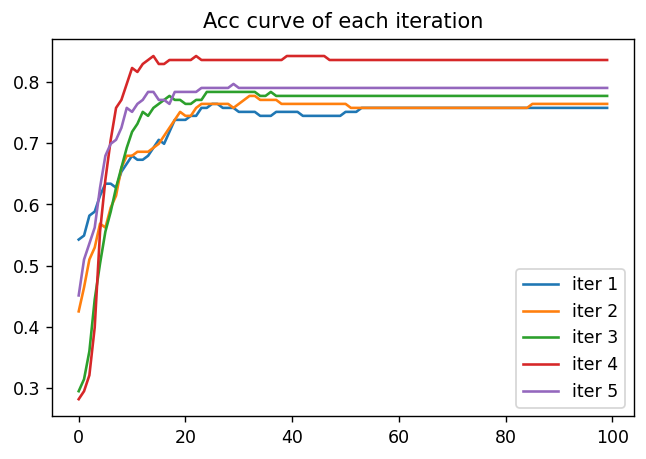

Mean acc of 5 Folds Cross Validation is: 0.7856209150326797


In [48]:
acc = {}
plt.figure(dpi=125)
for i in range(n_folds):
    X_test = X_Folds[i]
    Y_test = Y_Folds[i]
    X_train, Y_train = [], []
    for j in range(n_folds):
        if j != i:
            X_train.append(X_Folds[i])
            Y_train.append(Y_Folds[i])
    X_train = pd.concat(X_train, ignore_index=True)
    Y_train = pd.concat(Y_train, ignore_index=True)
    
    clf = LogisticClassifier(alpha=0.7, lambda_=0.01 ,random_state=i, max_iter=100)
    clf.fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)
    acc[i] = sum(Y_test == Y_pred) / len(Y_test)
    plt.plot(clf.score_list, label=f'iter {i+1}')

plt.title('Acc curve of each iteration')
plt.legend()
plt.show()
print(f'Mean acc of {n_folds} Folds Cross Validation is: {np.mean(list(acc.values()))}')